In [1]:
# softmax从0开始
import torch
from IPython import display
from d2l import torch as d2l

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) # load_data_fashion_mnist函数的具体实现我们在fashion_mnist里面敲了一遍，这里直接用写好的

num_inputs = 784 # 28 * 28 = 784 ，一个图片的像素个数
num_outputs = 10 # 输出是长度为10的vector，每个数字代表了对应label的概率，因此，我们这里是一个二层的网络

W = torch.normal(0, 0.01, (num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [3]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 每行的总和为1

X = torch.tensor([[1,2,3],
                  [1,5,6]])
print(softmax(X))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0049, 0.2676, 0.7275]])


In [4]:
def net(X):
    X = X.to('cuda')
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b) # 传入网络的X需要整成 batch_size * num_input的形状

# 这是损失函数
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y]) # 相当于按照这种顺序取出element并整成数组： y_hat[0][y[0]] 、 y_hat[1][y[1]] 、....y_hat[y.len - 1][y[y.len - 1]]

y_hat = torch.tensor([[0.3, 0.5, 0.2],
                      [0.2, 0.1, 0.9]])
y = torch.tensor([1, 1])
print(cross_entropy(y_hat, y))

tensor([0.6931, 2.3026])


In [5]:
# 模型预测的准确率，找出正确预测的个数，除以label（也就是y）的总个数，返回的是0-1
def accuracy(y_hat, y):
    y = y.to('cuda')
    if len(y_hat.shape) > 0 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 如果预测值是二维的，且列数大于1（如果等于1就是一个列向量，不需要处理），就仅读取每一行最大的元素所在的列下标（注意不是读最大值）
    '''
    现在y_hat的每一行只有一个元素，其值为模型对于该输入做出的预测，是一个整数
    直接拿去与y按元素比较，返回的list中true的个数就是预测正确的个数
    '''
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum() / len(y))

class Accumulator:
    '''在n个变量上累加'''
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    # 评估任意模型的准确率
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式 --> 有啥用？不会进行反向传播？
    metric = Accumulator(2) # 一个累加器
    print(data_iter)
    for X, y in data_iter:
        metric.add(accuracy(net(X.cuda(0)), y.cuda(0)), y.numel()) # net(X)就是模型对于这个mini-batch的输出, y.numel()就是y的个数
    return metric[0] / metric[1]

accuracy(y_hat, y)

0.5

In [6]:
evaluate_accuracy(net, test_iter)

TypeError: __array__() takes 1 positional argument but 2 were given

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
    '''

    :param net:
    :param train_iter:
    :param loss:
    :param updater:
    :return: 第一个返回值是loss，第二个返回值是acc
    '''
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        # 如果优化器是利用torch自带的类实现的
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

AttributeError: module 'torch.cuda' has no attribute '_UntypedStorage'

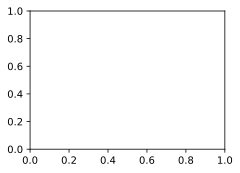

In [19]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size) # 包装了个sgd


num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)